2.1666455
2.1666455
2.1666455
2.1666455
2.1666455
2.1666455


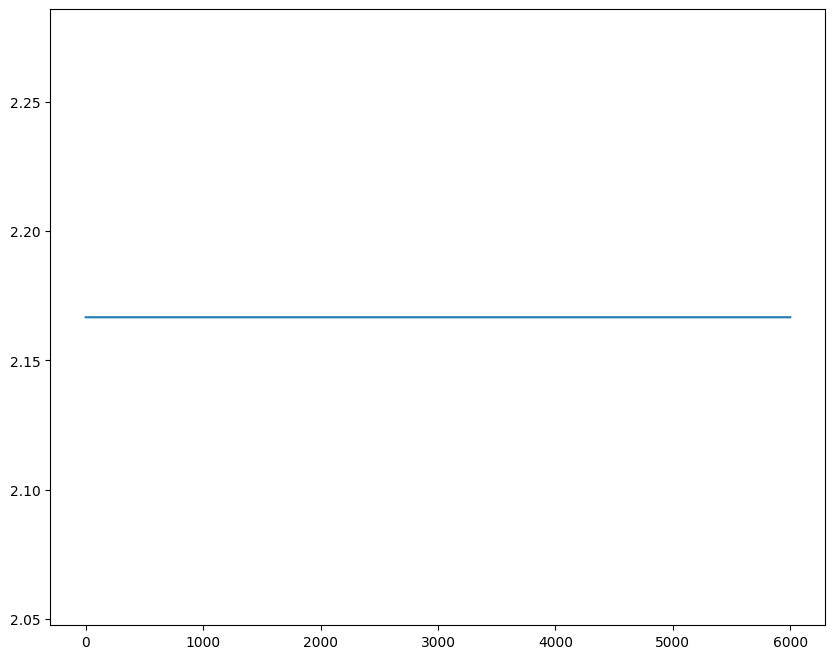

In [1]:
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.adam import Adam

model = nn.Sequential(
    nn.Linear(1, 32),
    nn.Tanh(),
    nn.Linear(32, 1)
)

lr = 1e-3
optim = Adam(model.parameters(), lr=lr)

def ode_system(t,net):
    t=t.reshape(-1,1)
    t = torch.tensor(t, dtype=torch.float32,requires_grad=True)
    t_0 = torch.zeros((1,1))
    one = torch.ones((1,1))

    u = net(t)
    u_t = torch.autograd.grad(u, t , grad_outputs=torch.ones_like(u), create_graph=True)[0]

    ode_loss = u_t - torch.cos(2*np.pi*t)
    IC_loss = net(t_0) - one

    square_loss = torch.square(ode_loss) + torch.square(IC_loss)
    total_loss = torch.mean(square_loss)
    return total_loss

train_t = (np.random.rand(30)*2).reshape(-1,1)
train_loss_record = []

for itr in range(6000):
    train_loss = ode_system(train_t,model)
    train_loss_record.append(train_loss.detach().numpy())

    grad_w = torch.autograd.grad(train_loss, model.parameters())
    optim.zero_grad()

    optim.step()

    if itr % 1000 == 0:
        print(train_loss.detach().numpy())

import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
plt.plot(train_loss_record)
plt.show()




In [2]:
t_0 = torch.ones((1,1))
print(t_0)

tensor([[1.]])


In [3]:
import torch
import torch.nn as nn
from torch.autograd import Variable
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
import numpy as np

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.hidden_layer1 = nn.Linear(2,5) #input num:2 for x,t
        self.hidden_layer2 = nn.Linear(5,5)
        self.hidden_layer3 = nn.Linear(5,5)
        self.hidden_layer4 = nn.Linear(5,5)
        self.hidden_layer5 = nn.Linear(5,5)
        self.output_layer = nn.Linear(5,1)

    def forward(self, x,t):
        inputs = torch.cat([x,t],axis=1) # combined two arrays of 1 columns each to one array of 2 columns
        layer1_out = torch.sigmoid(self.hidden_layer1(inputs))
        layer2_out = torch.sigmoid(self.hidden_layer2(layer1_out))
        layer3_out = torch.sigmoid(self.hidden_layer3(layer2_out))
        layer4_out = torch.sigmoid(self.hidden_layer4(layer3_out))
        layer5_out = torch.sigmoid(self.hidden_layer5(layer4_out))
        output = self.output_layer(layer5_out)
        return output

net = Net()
net = net.to(device)
mse_cost_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters())
#optimizer = torch.optim.LBFGS(net.parameters())


In [4]:
def f(x,t, net):
    u = net(x,t)
    u_x = torch.autograd.grad(u.sum(), x, create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_t = torch.autograd.grad(u.sum(), t, create_graph=True)[0]
    pde = u_t - 0.01*u_xx-2*u*(1-u)
    #pde = u_x - 2*u_t - u #Exact solution's error(should be 0)
    return pde


In [5]:
x_bc = np.random.uniform(low=0.0, high=1.0, size=(500,1))
t_bc = np.zeros((500,1))
u_bc = 0.5*(np.sin(np.pi*x_bc))**2

#u_bc = 6*np.exp(-3*x_bc) #BC when t=0


In [6]:
iterations = 20000
previous_validation_loss = 99999999.0
loss_count=[]
for epoch in range(iterations):
    optimizer.zero_grad()

    pt_x_bc = Variable(torch.from_numpy(x_bc).float(), requires_grad=False).to(device)
    pt_t_bc = Variable(torch.from_numpy(t_bc).float(), requires_grad=False).to(device)
    pt_u_bc = Variable(torch.from_numpy(u_bc).float(), requires_grad=False).to(device)

    net_bc_out = net(pt_x_bc, pt_t_bc)
    mse_u = mse_cost_function(net_bc_out, pt_u_bc)

    x_collocation = np.random.uniform(low=0.0, high=1.0, size=(500,1)) #Fixed range
    t_collocation = np.random.uniform(low=0.0, high=1.0, size=(500,1)) #Fixed range
    all_zeros = np.zeros((500,1))

    pt_x_collocation = Variable(torch.from_numpy(x_collocation).float(), requires_grad=True).to(device)
    pt_t_collocation = Variable(torch.from_numpy(t_collocation).float(), requires_grad=True).to(device)
    pt_all_zeros = Variable(torch.from_numpy(all_zeros).float(), requires_grad=False).to(device)

    f_out = f(pt_x_collocation, pt_t_collocation, net)
    mse_f = mse_cost_function(f_out, pt_all_zeros)

    loss = mse_u + mse_f

    loss.backward()


    optimizer.step()

    with torch.autograd.no_grad():
        loss_count.append(loss.item())
        if epoch % 1000 == 0:
    	    print(epoch,"Traning Loss:",loss.item())


0 Traning Loss: 0.5028511881828308
1000 Traning Loss: 0.07846709340810776
2000 Traning Loss: 0.0784647986292839
3000 Traning Loss: 0.07840541005134583
4000 Traning Loss: 0.03317458555102348
5000 Traning Loss: 0.03233908489346504
6000 Traning Loss: 0.032302193343639374
7000 Traning Loss: 0.029863376170396805
8000 Traning Loss: 0.0020901127718389034
9000 Traning Loss: 0.0005955520318821073
10000 Traning Loss: 0.00042062532156705856
11000 Traning Loss: 0.00019763322779908776
12000 Traning Loss: 0.00011659134906949475
13000 Traning Loss: 6.783053686376661e-05
14000 Traning Loss: 6.443490565288812e-05
15000 Traning Loss: 4.712987720267847e-05
16000 Traning Loss: 3.870702494168654e-05
17000 Traning Loss: 3.7010446249041706e-05
18000 Traning Loss: 3.0340710509335622e-05
19000 Traning Loss: 2.464058889017906e-05


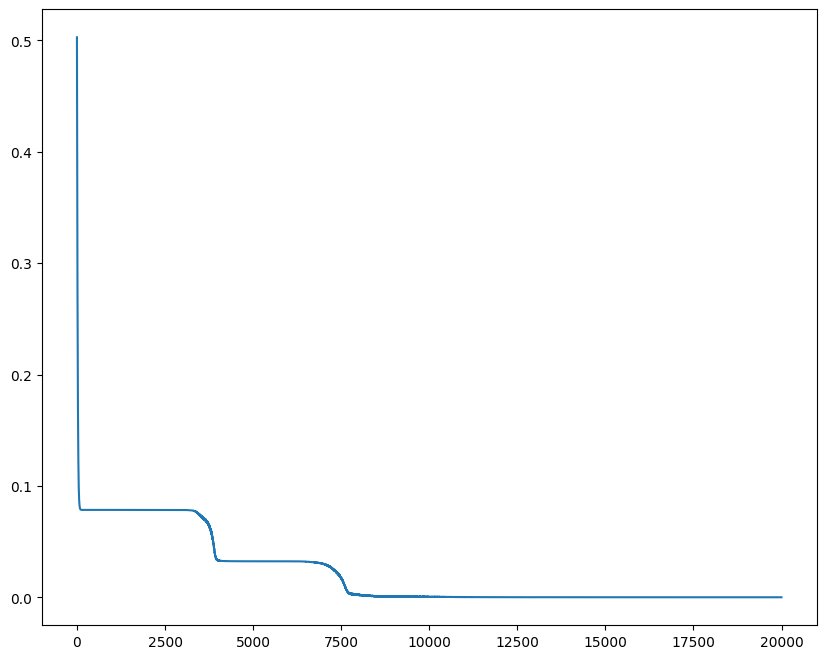

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
plt.plot(loss_count)
plt.show()

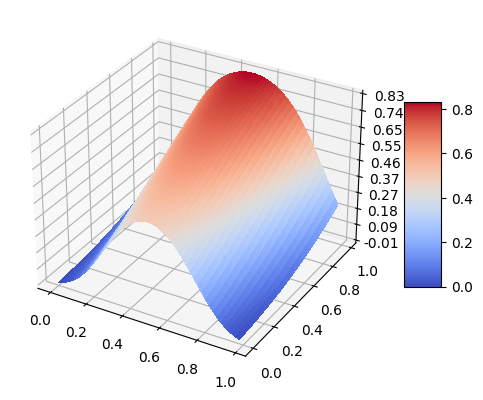

In [8]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')  # Use add_subplot to create a 3D axes

x=np.arange(0,1,0.02)
t=np.arange(0,1,0.02)
ms_x, ms_t = np.meshgrid(x, t)
## Just because meshgrid is used, we need to do the following adjustment
x = np.ravel(ms_x).reshape(-1,1)
t = np.ravel(ms_t).reshape(-1,1)

pt_x = Variable(torch.from_numpy(x).float(), requires_grad=True).to(device)
pt_t = Variable(torch.from_numpy(t).float(), requires_grad=True).to(device)
pt_u = net(pt_x,pt_t)
u=pt_u.data.cpu().numpy()
ms_u = u.reshape(ms_x.shape)

surf = ax.plot_surface(ms_x,ms_t,ms_u, cmap=cm.coolwarm,linewidth=0, antialiased=False)



ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
[-0.0052174   0.00137092  0.00963113  0.01995075  0.03273377  0.04834817
  0.06705517  0.08894059  0.11387125  0.14149547  0.17128843  0.2026187
  0.23481385  0.26720464  0.29915258  0.33006364  0.3593974   0.38667667
  0.4114951   0.4335164   0.45247972  0.46818736  0.48050106  0.4893275
  0.49461082  0.49632365  0.49446037  0.48903668  0.48009014  0.46768576
  0.45192116  0.43293977  0.4109372   0.3861714   0.35896885  0.3297264
  0.29891133  0.26705253  0.23473978  0.20261192  0.17134191  0.1416091
  0.11404866  0.08918479  0.06736413  0.04871261  0.03313765  0.02037519
  0.01005784  0.00178495]


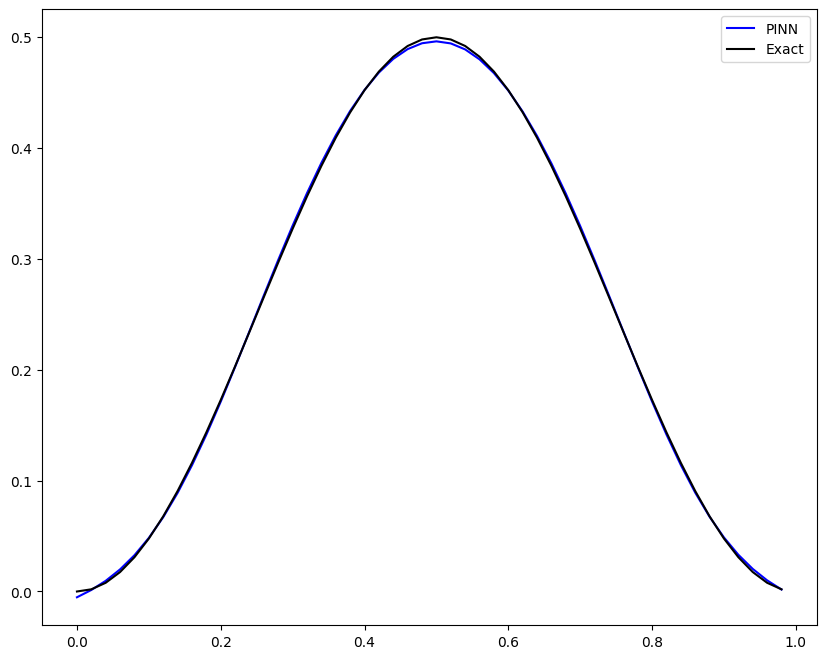

In [20]:
print(ms_t[0])
print(ms_u[0])

ms_u_x25 = [ms_u[i][25] for i in range(len(ms_u))]
y1=0.5*(np.sin(np.pi*ms_x[0]))**2

plt.figure(figsize=(10,8))
plt.plot(ms_x[0],ms_u[0],'b',label='PINN')
plt.plot(ms_x[0],y1,'k',label='Exact')
plt.legend(loc='best')
plt.show()
